In [1]:
 # -*-encoding:utf-8-*-
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 8,  # fontsize for x and y labels (was 10)
    'axes.titlesize': 8,
    'font.size': 8,  # was 10
    'legend.fontsize': 6,  # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}

oneFig_Title_FontSize = 15
oneFig_Axis_FontSize = 13
subplot_Title_FontSize = 10
subplot_FontSize = 5

glb_fig_size = (10, 4)
glb_dpi = 400
glb_show = False
glb_mark_size = 2


col_names = ['M', 'N', 'K',
             'MAGMA_Tflops/s', 'ms1',
             'cuBLAS_Tflops/s', 'ms2',
             'magma_L1_hit_rate', 'magma_L2_hit_rate',
             'cublas_L1_hit_rate', 'cublas_L2_hit_rate',
             'magma_flo', 'cu_flo',
             'magma_flo_mkn2', 'cu_flo_mkn2',
             'mat'
             ]

col_len = len(col_names)
M = col_names[0]
N = col_names[1]
mgm_gflpos = col_names[3]
mgm_time = col_names[4]
cu_gflps = col_names[5]
cu_time = col_names[6]
magma_l1 = col_names[7]
magma_l2 = col_names[8]
cublas_l1 = col_names[9]
cublas_l2 = col_names[10]
mgm_flo = col_names[11]
cu_flo = col_names[12]
mgm_flo_mkn2 = col_names[13]
cu_flo_mkn2 = col_names[14]
mat = col_names[15]

cu_gflps_64 = cu_gflps + '_64'
cu_gflps_32 = cu_gflps + '_32'
cu_gflps_16 = cu_gflps + '_16'
cu_flo_mkn2_64 = cu_flo_mkn2+'_64'


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )
    return new_cmap


cmap_64 = plt.get_cmap("Blues")
cmap_64 = truncate_colormap(cmap_64, 0.2, 0.9)
cmap_32 = plt.get_cmap("Oranges")
cmap_32 = truncate_colormap(cmap_32, 0.2, 0.9)
cmap_16 = plt.get_cmap("Greens")
cmap_16 = truncate_colormap(cmap_16, 0.2, 0.9)

cmap_total = [cmap_64, cmap_32, cmap_16]

img_dir = "./"

In [2]:


# 绘制在一张图中
def draw_pnt_all_in_one(img_dir='./img/', x=M, y=cublas_l2, c=cu_gflps,
                        x_y_title=['M', 'L2 Hit Rate',
                                   'cuBLAS TFlops on RTX 4090'],
                        file_lst=['dgemmresult.csv',
                                  'sgemmresult.csv', 'hgemmresult.csv'],
                        label=['FP64', 'FP32', 'FP16'],
                        x_use_log=False,
                        MeqN=False):
    sns.set()
    sns.set_style("whitegrid")

    x_label, y_label, title = x_y_title
    ax = plt.figure(figsize=glb_fig_size, dpi=glb_dpi)
    fig = ax

    plt.xlabel(x_label + (' ($log_2$ scale)' if x_use_log else ''), fontsize=oneFig_Axis_FontSize)
    plt.ylabel(y_label, fontsize=oneFig_Axis_FontSize)

    plt.subplots_adjust(right=None, left=0.03, wspace=0.05, hspace=0.05)

    all_max_L2_hit_rate, all_min_L2_hit_rate = -1, 101

    for cnt, file in enumerate(file_lst):
        dgemm_result = pd.read_csv(file)
        max_d_flps = max(dgemm_result[c])
        min_d_flps = min(dgemm_result[c])
        norm_d = matplotlib.colors.Normalize(min_d_flps, max_d_flps)

        max_d_L2_hit_rate = max(dgemm_result[y])
        min_d_L2_hit_rate = min(dgemm_result[y])
        all_max_L2_hit_rate = max(all_max_L2_hit_rate, max_d_L2_hit_rate)
        all_min_L2_hit_rate = min(all_min_L2_hit_rate, min_d_L2_hit_rate)
        if (MeqN):
            tdgemm_result = dgemm_result[dgemm_result[M] == dgemm_result[N]]
        else:
            tdgemm_result = dgemm_result
        if x_use_log:
            tdgemm_result[x] = np.log(tdgemm_result[x])

        fp64 = plt.scatter(tdgemm_result[x], tdgemm_result[y], c=tdgemm_result[c],
                           cmap=cmap_total[cnt], s=glb_mark_size, label=label[cnt], norm=norm_d)

        if cnt == len(file_lst) - 1:
            plt.colorbar(fp64, pad=0.03)
        else:
            plt.colorbar(fp64, pad=-0.015)

    # fig.canvas.manager.window.showMaximized()

    plt.ylim(0, 100)
    plt.legend(loc=4, markerscale=3.6)
    
    file_num = len(file_lst)
    baseX = 29.9
    if file_num == 2:
        plt.text(baseX, -11.5, "FP32")
        plt.text(baseX+2, -11.5, "FP64")
        plt.text(baseX-0.5, -24, "TFlops Reference")
    elif file_num == 3:
        plt.text(baseX, -11.5, "FP16")
        plt.text(baseX+2, -11.5, "FP32")
        plt.text(baseX+4.5, -11.5, "FP64")
        plt.text(baseX+0.5, -24, "TFlops Reference")

    plt.savefig(img_dir + title.split(' ')
                [0] + '_(' + x + ')_(' + y + ')_' +
                ('(M=N)' if MeqN else '') + '_ALLinOne' + ".pdf", format="pdf", bbox_inches='tight', dpi=400, pad_inches=0.0)


In [3]:


def process_tall_skinny():

    data_dir = '../data/'

    result_file_lst = ['ncu-dgemm.csv', 'ncu-sgemm.csv', 'ncu-hgemm.csv']
    result_file_lst = [(data_dir + elem) for elem in result_file_lst]

    cu_flops_h2_x_y_title = ['Floating Point Operations',
                             'L2 Hit Rate (%)', 'cuBLAS TFlops on RTX 4090-Tall&Skinny']

    draw_pnt_all_in_one(img_dir=img_dir, x=cu_flo_mkn2, y=cublas_l2, c=cu_gflps,
                        x_y_title=cu_flops_h2_x_y_title,
                        file_lst=result_file_lst,
                        label=['FP64', 'FP32', 'FP16'],
                        x_use_log=True,
                        MeqN=False)
    pass

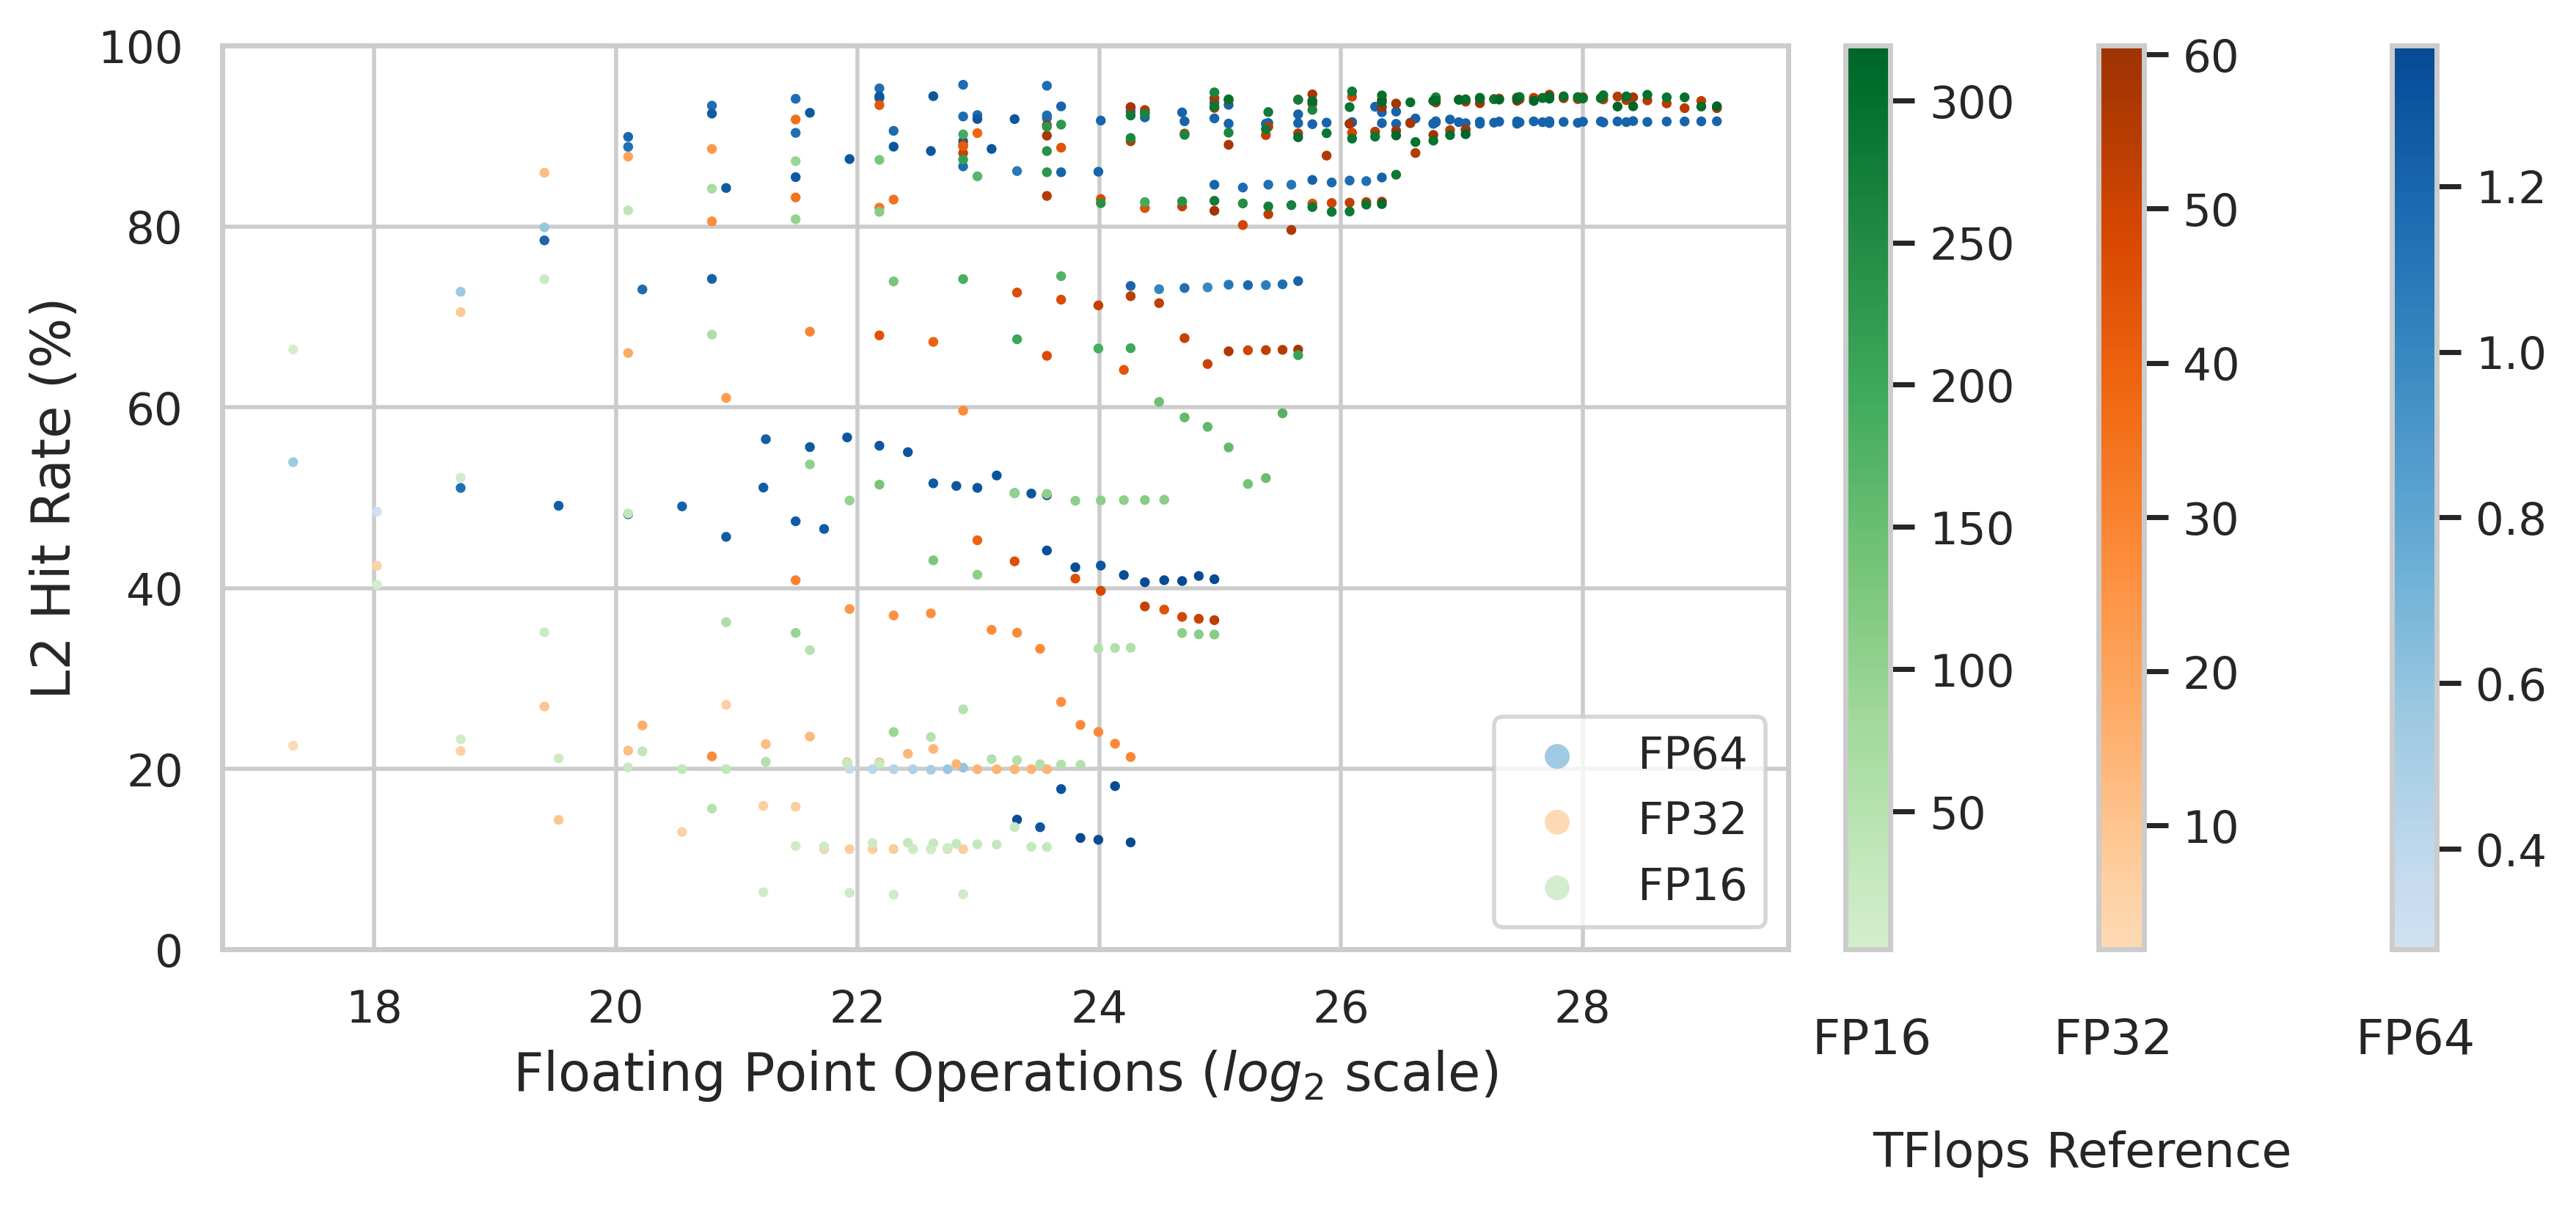

In [4]:
process_tall_skinny()